# Tutorial 4: Training deeptb-e3 model for Silicon

## Introduction
**DeePTB** is a method that uses deep learning to accelerate first-principles electronic structure simulations.

### Version Features
- **v1**: Constructed tight-binding (TB) models with first-principles accuracy (DeePTB-SK)
- **v2.0-2.1**: Added E3 equivariant networks to represent single-electron operators (Hamiltonian, density matrix, and overlap matrix) (DeePTB-E3)
- **v2.2**: Incorporated built-in SK empirical parameters covering commonly used elements across the periodic table

Through these capabilities, DeePTB provides multiple approaches to accelerate electronic structure simulations of materials.

### Learning Objectives
1. Understanding how to setup DeePTB-E3 model to train on equivariant LCAO Kohn-Sham (KS) Hamiltonian.
2. Get a highly accurate DeePTB-E3 model of single crystal silicon.
3. Get familiar with DeePTB's properties calculation module.

## Content

* [Method](#method)
  * [1. What is DeePTB-E3](#whatis)
  * [2. What to do with DeePTB-E3](#whattodo)
* [Practice](#practice)
  * [1. Prepare the data](#dataprepare)
  * [2. Model Training](#train)
  * [3. Properties Calculation](#application)
* [More Method](#moremethod)
  * [Parametrize E3 features](#e3representation)
  * [Invariant Representation of Overlap Matrix](#overlaprepresentation)
  * [Model Structure](#modelarchitecture)

## Method: <a id ='method'></a>
Here we briefly introduce the method of DeePTB-E3 from its functional and operational perspective. For more theoretical and technical parts, please refer to the [**More Method**](#moremethod) section or our paper: [SLEM ICLR2025](https://openreview.net/pdf?id=kpq3IIjUD3).
### What is DeePTB-E3: <a id = 'whatis'></a>
**DeePTB-E3** is a flexible function in DeePTB package supporting training a neural network model to predict directly the LCAO Quantum Operators, including Hamiltonian, Density Matrix and Overlap Matrix of Kohn-Sham DFT. The training data are generated directly via LCAO DFT packages. We employ a strictly local equivariant model, that preserves the physics, which enables efficient learning and a reduced amount of data required.

### What to do with DeePTB-E3 <a id = 'whattodo'></a>
DeePTB-E3 model, after being trained, can predict DFT Hamiltonian with an extremely lower cost than conventional DFT. You can use DeePTB-E3:
1. Do high-throughput calculations on Molecular Dynamics trajectory, combinations of structure, elements etc.
2. Predicting on large structure while training on the dataset of smaller ones.

## Practice <a id ='practice'></a>

### **1. Prepare the Data** <a id ='dataprepare'></a>

DeePTB need to calculate output from the LCAO DFT as the input dataset.

For illustration, we have prepared the dataset including crystalline silicon in DeePTB/examples/e3/data folder. The data are generated via ABACUS DFT software, using an SZP basis, containing one s and one p orbital. The cutoff of the LCAO basis is 7au, which indicates the largest bond should be smaller than 14au, which is around 7.408 angstrom. In DeePTB, we use angstroms as our length unit, and eV as the energy unit.

To make life easier, we provide [dftio](https://github.com/floatingCatty/dftio) to transform the DFT output data into a trainable dataset format, we refer to the former tutorial and the front page of [dftio](https://github.com/floatingCatty/dftio) repository for usage guide.

The directory of these examples looks like：
```bash
deeptb/examples/e3/
|-- band.json
|-- band_plot.py
|-- data
|   |-- Si64.0
|   |   |-- atomic_numbers.dat
|   |   |-- basis.dat
|   |   |-- cell.dat
|   |   |-- hamiltonians.h5
|   |   |-- kpoints.npy
|   |   |-- overlaps.h5
|   |   |-- pbc.dat
|   |   `-- positions.dat
|   |-- Si64.vasp
|   `-- info.json
|-- input_short.json
|-- input_short_cpu.json
`-- ref_model
    `-- nnenv.ep1474.pth
```

We can see the data folder contains a single frame Si.0. To inform the **DeePTB** that this is a dataset, we need to write a very simple `info.json', as:
```JSON
{
        "nframes": 1,
        "pos_type": "cart",
        "pbc": true
}
```
Where 'nframes' indicates the `Si64.0` folder contains only a single structure, `pos_type` suggests the `positions.dat` is written with absolute position. and `pbc` suggest it is a system with periodic boundary conditions on all `x`, `y` and `z` plains.

Now we have already prepared a training dataset for DeePTB-E3.

**To make life easier**, we highly recommend using **dftio** to prepare the data. With the DFT output, dftio can preprocess the data in parallel with only one line of command. Here we give an example to show.


In [ ]:
import os
os.chdir("/root/soft/dftio/test/data")

In the folder, there sits an abacus DFT calculation results. The directory looks like:
```
abacus
|-- INPUT
|-- OUT.ABACUS
|   |-- INPUT
|   |-- STRU_SIMPLE.cif
|   |-- data-HR-sparse_SPIN0.csr
|   |-- istate.info
|   |-- kpoints
|   |-- running_scf.log
|   `-- warning.log
`-- STRU
```

We can transform this into the machine learning readable format with one line:

In [ ]:
!dftio parse -r ./ -p abacus -o ./test -ham

In [ ]:
!tree test

You can see the test folder we generated, containing  the prepared data of a single MoS2 frame with its Hamiltonian. The command has several options. Here, the `-r` and `-p` indicate the root and prefix of the DFT output folders to be processed. For example, for a current folder with abacus as its name, we use `-r ./` and `-p abacus`. The `-p` is the prefix that anchors on all the folders with this prefix string; therefore, by a single line, we can locate multiple DFT outputs. `-o` indicates the output directory, containing the processed data. Those are the essential flags.

Now, to decide which data should be processed, we need to specify the parsing of physical quantities. The tag includes `-ham`, `-ovp`, `-dm`, `-eig`, representing the Hamiltonian, Overlap Matrix, Density Matrix and the kpoints \& energy eigenvalues. Here we use `-ham` so the processed folder will contain `hamiltonians.h5` parsed from `data-HR-sparse_SPIN0.csr` of the abacus output.

In extra, we can specify the DFT software used to generated your raw data by `-m`. The default `-m` value are `abacus`. Other supported DFT software includes: `gaussian`, `vasp`, `rescu` and `siesta`.

If you have a large amount of data, to parse it efficiently, you can use `-n j` tag to launch the j processors simultaneously to handle the data.

### **2. Model Training** <a id ='train'></a>

The `input_short.json` file contains the least number of parameters that are required to start training the DeePTB-E3 model, we list some important parameters:

```JSON
"common_options": {
    "basis": {
        "Si": "1s1p"
    },
    "device": "cpu",
    "overlap": true
}
```
In `common_options`, here are the essential parameters. The `basis` should align with the DFT calculation, so 1 `s` and 1 `p` orbitals would result in a `1s1p` basis. The `device` can either be `cpu` or `cuda`, but we highly recommend using `cuda` if GPU is available. The `overlap` tag controls whether to fit the overlap matrix together. Benefitting from our parameterization, the fitting overlap only brings **negligible costs**, but is very convenient when using the model. So we highly suggest that you to do it.

Here comes the `model_options`:
```JSON
"model_options": {
    "embedding": {
        "method": "slem",
        "r_max": {
            "Si": 7.4
        },
        "irreps_hidden": "32x0e+32x1o+16x2e",
        "n_layers": 3,
        "avg_num_neighbors": 51,
        "tp_radial_emb": true
    },
    "prediction":{
        "method": "e3tb",
        "neurons": [64,64]
    }
}
```

The `model_options` contains `embedding` and `prediction` parts, denoting the construction of representation for equivariant features, and arranging and rescaling the features into quantum operators sub-blocks such as Hamiltonian, density and overlap matrix.

In `embedding`, the `method` supports `slem` and `lem` for now, where `slem` has a strictly localised dependency, which has better transferability and data efficiency, while `lem` has an adjustable semi-local dependency, which has better representation capacity, but would require a little more data. 

`r_max` stands for the maximum bond length. Since the cutoff radius for the DFT LCAO orbital is 7 au, which means the largest bond would be less than 14 au. Therefore, it should be set as 7.4 angstrom.

For `irreps_hidden`, this parameter defines the size of the hidden equivariant irreducible representation, which decides most of the power of the model. There are certain rules to define this parameter. But for quick usage, we provide a tool to do basis analysis to extract essential irreps:

```IPYTHON
In [1]: from dptb.data import OrbitalMapper

In [2]: idp = OrbitalMapper(basis={"Si": "1s1p"})

In [3]: idp.get_irreps_ess()
Out[3]: 2x0e+1x1o+1x2e
```

This is the number of independent irreps contained in the basis. Irreps configured should be multiple times of this essential irreps. The number can vary with a pretty large freedom, but all the types, for example ("0e", "1o", "2e") here, should be included for all. We usually take a descending order starting from "32", "64", or "128" for the first "0e" and decay by half for the latter high-order irreps. For general rules of the irreps, the user can read the advanced topics in the DeePTB document, but for now, you are safe to ignore!

`n_layers` is the number of hidden layers of the embedding networks, usually it should be set between 3-5. `avg_num_neighbors` is the normalisation constant of the node feature.`tp_radial_emb` is a bool type value, representing whether to explicitly include radial information in the SO2 tensor product.

In `prediction`, we should use the `e3tb` method to require the model output features using **DeePTB-E3** format. The neurons are defined for a simple MLP to predict the slater-koster-like parameters for predicting the overlap matrix, for which [64,64] is usually fine.

Now everything is prepared! We can using the following command and we can train the first model:

In [ ]:
import os
os.chdir("/root/soft/DeePTB/examples/e3")

In [ ]:
# Run the training
# GPU: 
!dptb train ././input_short_cpu.json -o ./e3_silicon
# If GPU is not available, please comment the line above and use the command below.
#!dptb train ./input_short_cpu.json -o ./e3_silicon

Here ``-o`` indicates the output directory. During the fitting procedure, we can see that the loss curve of hBN decreases consistently. When finished, we get the fitting results in folders ```e3_silicon```.

Aftering training, we can use directly our model for electronic structure calculation. Since overlap is fitted along with others, the calculation can be used independently to the source DFT software. Here we illustrate this with electron band structure plotting. We can directly run the prepared band plotting config:

训练完成后，我们可以画图看看能带拟合怎么样了，需要准备这样的能带绘制参数：
```json
{   
    "task_options": {
        "task": "band",
        "kline_type":"abacus",
        "kpath":[
                [0.0000000000,   0.0000000000,   0.0000000000,   20],   
                [0.5000000000,   0.0000000000,   0.0000000000,   1],               
                [0.0000000000,   0.5000000000,   0.0000000000,   20],    
                [0.0000000000,   0.0000000000,   0.0000000000,   20],     
                [0.0000000000,   0.0000000000,   0.5000000000,   1],    
                [-0.500000000,  -0.5000000000,   0.5000000000,   20],                
                [0.0000000000,   0.0000000000,   0.0000000000,   20],               
                [0.0000000000,  -0.5000000000,   0.5000000000,   1 ],
                [-0.500000000,   0.0000000000,   0.5000000000,   20],
                [0.0000000000,   0.0000000000,   0.0000000000,   20],
                [0.5000000000,  -0.5000000000,   0.0000000000,   1 ]
                ],
        "klabels":["G","X","Y","G","Z","R_2","G","T_2","U_2","G","V_2"],
        "nel_atom":{"Si":4},
        "E_fermi":0.0,
        "emin":-7,
        "emax":18
    }
}
```

TBPLaS is not installed. Thus the TBPLaS is not available, Please install it first.
 
 
#################################################################################
#                                                                               #
#                                                                               #
#      ██████████                     ███████████  ███████████ ███████████      #
#     ░░███░░░░███                   ░░███░░░░░███░█░░░███░░░█░░███░░░░░███     #
#      ░███   ░░███  ██████   ██████  ░███    ░███░   ░███  ░  ░███    ░███     #
#      ░███    ░███ ███░░███ ███░░███ ░██████████     ░███     ░██████████      #
#      ░███    ░███░███████ ░███████  ░███░░░░░░      ░███     ░███░░░░░███     #
#      ░███    ███ ░███░░░  ░███░░░   ░███            ░███     ░███    ░███     #
#      ██████████  ░░██████ ░░██████  █████           █████    ███████████      #
#     ░░░░░░░░░░    ░░░░░░   ░░░░░░  ░░░░░           ░░░░░    ░░░░░░░░░░░       #
#         

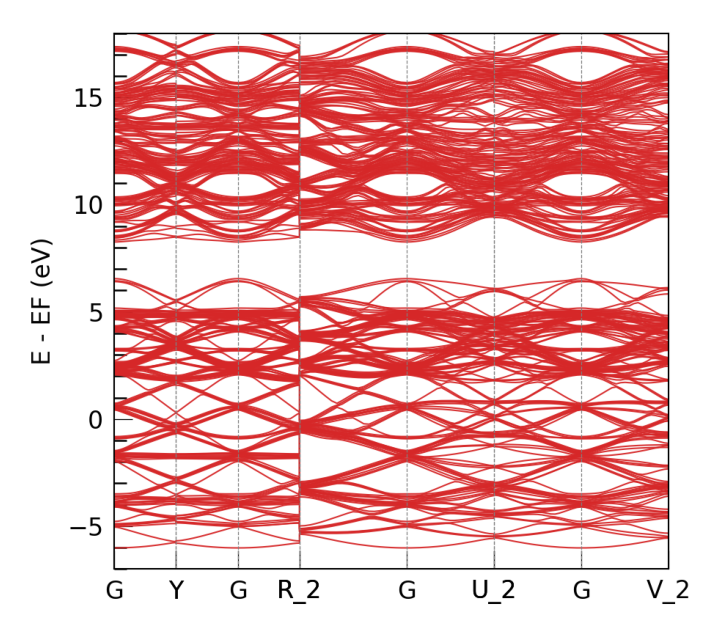

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [5]:
!dptb run band.json -i ./ref_model/nnenv.ep1474.pth -o band -stu ./data/Si64.vasp

# display the band plot:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image_path = f'./band/results/band.png'
img = mpimg.imread(image_path)
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

Now you know how to train a **DeePTB-E3** model to predict Hamiltonian Matrix and Overlap Matrix. If you want further introduction of the features and more advanced usages, please read the [official document](https://deeptb.readthedocs.io/en/latest/) of **DeePTB**.

## More Method<a id ='moremethod'></a>

**DeePTB-E3** are functions based on the core design of a Strictly Local Equivariant Message Passing network (SLEM) model to represent single-electron operator matrices, including the Hamiltonian, density matrix, overlap matrix, and so on. This innovative approach is intended to accelerate first-principles electronic structure and property calculations. DeePTB employs an equivariant representation for the density matrix and Hamiltonian, whereas for overlap integrals, though they can also be represented equivariantly, given their strictly two-centre character, we achieve a more efficient invariant representation via Slater–Koster parameterisation.


### Parametrization of the Equivariant Representation: <a id ='e3representation'></a>

In the LCAO-basis DFT framework, a single-electron operator $\hat{O}$ (such as the Hamiltonian or density matrix) obeys equivariance under the E(3) group, and thus can be expressed using tensorized features from group theory. The E(3) group includes spatial rotations, translations, and reflections. Translation symmetry is automatically satisfied by operating only on relative coordinates, whereas rotations and reflections require explicit treatment.

In the LCAO basis, the matrix elements of $\hat{O}$ are written as:

$$O^{i,j}_{l_1,l_2,m_1,m_2} = \langle i, l_1, m_1 | \hat{O} | j, l_2, m_2 \rangle$$

where $i$ and $j$ label atomic positions, and $l_1,m_1$ and $l_2,m_2$ denote the orbitals at positions $i$ and $j$ respectively. Here, $m_1$ and $m_2$ are the magnetic quantum numbers associated with angular momenta $l_1$ and $l_2$.

Under a rotation $R$ of the system coordinates, equivariance demands that the operator matrix elements transform as:
$$O'^{i,j}_{l_1,l_2,m'_1,m'_2} = \sum_{m_1,m_2} D(R)^{l_1}_{m_1,m'_1} D^*(R)^{l_2}_{m_2,m'_2} O^{i,j}_{l_1,l_2,m_1,m_2}$$

where $O'$ is the rotated (equivariant) representation matrix and $D(R)^l_{m,m'}$ is the Wigner-D matrix of order $l$.

Applying the Wigner–Eckart theorem, we can decompose the operator into irreducible features:

$$o^{i,j}_{l_3,m_3} = \sum_{l_1,m_1,l_2,m_2} C^{(l_3,m_3)}_{(l_1,m_1)(l_2,m_2)} O^{i,j}_{l_1,l_2,m_1,m_2}$$

Here $l_3$ ranges over $\lvert l_1 - l_2\rvert \le l_3 \le l_1 + l_2$. Edge $(i\neq j)$ and node $(i=j)$ features $o^{i,j}_{l_3,m_3}$ are grouped by the index $m$ into vectors $\mathbf{o}^{i,j}_{c,l}$, where $c$ indexes the multiplicity of each $l$. To align with the network outputs, we normalise these target features:

$$o^{i,i/j}_{c,l} = \sigma^{Z_i,Z_{i/j}}_{c,l} \hat{o}^{i,i/j}_{c,l} + \mu^{Z_i,Z_{i/j}}_{c,l} \delta_{l,0}$$

where $Z_i, Z_j$ are atomic numbers of atoms $i$ and $j$, and $\sigma^{Z_i,Z_{i/j}}_{c,l}$ and $\mu^{Z_i,Z_{i/j}}_{c,l}$ are dataset‐derived scale and bias parameters for each atom or atom‐pair.

The network is trained to produce aggregated node and edge features $\mathbf{n}^i_{c,l}, \mathbf{e}^{ij}_{c,l}$ that supervise the decomposed target features $\hat{o}^{i,i}_{c,l}$ and $\hat{o}^{i,j}_{c,l}$. Finally, we reconstruct the predicted operator matrix via the inverse Wigner–Eckart transform:

$$O^{i,j}_{l_1,l_2,m_1,m_2} = \sum_{l_3,m_3} C^{(l_3,m_3)}_{(l_1,m_1)(l_2,m_2)} o^{i,j}_{l_3,m_3}$$

This procedure ensures the representation respects rotational, translational, and reflection symmetries.


### Invariant Representation of Overlap Integrals <a id ='overlaprepresentation'></a>

The overlap matrix is defined as:

$$S^{i,j}_{l_1,l_2,m_1,m_2} = \langle i, l_1, m_1 | j, l_2, m_2 \rangle = \int \phi^{i,l_1}_{m_1}(r)\phi^{j,l_2}_{m_2}(r - r_{ij})dr$$

where $\phi^{i,l}_{m}$ are the LCAO basis functions. The overlap matrix naturally satisfies equivariance. Since this property derives entirely from the basis functions, we can rotate them so that the bond vector $r_{ij}$ aligns with the $z$-axis, reducing the matrix elements to scalars via:

$$\int \phi^{\prime i,l_1}_{m_1}(r)\phi^{\prime j l_2}_{m_2}(r - r_{ij})dr = s^{Z_i,Z_j}_{l_1,l_2,|m_1|}(r_{ij}) \delta_{m_1,m_2}$$

Here $\phi'$ denotes the orbitals rotated into the bond-aligned frame. The integral depends only on the two-centre parameters $Z_i, Z_j,$ and $r_{ij}$. We then learn a mapping from these atomic types and bond lengths to the scalar overlap parameters via a small MLP:

$$f_{l_1,l_2,|m|}(Z_i, Z_j, r_{ij}) = s^{Z_i,Z_j}_{l_1,l_2,|m_1|}(r_{ij}) \delta_{m_1,m_2}$$

Using these learned scalars, we build the overlap matrix in the bond-aligned frame and then rotate it back to the original coordinate system.

### Model Architecture <a id ='modelarchitecture'></a>
The **DeePTB-E3** module’s central innovation is the Strictly Local Equivariant Message Passing (SLEM) model for representing single-electron operator matrices. The SLEM architecture comprises:

1. **Input Encoding:** Encode atomic types, coordination numbers, distances, and other physico-chemical information into scalar hidden-state features.  
2. **Feature Initialisation:** Initialise edge features, hidden‐state features, and node features using the encoded scalars and spherical harmonics.  
3. **Feature Update Modules:** Iteratively update hidden‐state, node, and edge features via a series of strictly local node/edge message‐passing operations.  
4. **Quantum Operator Reconstruction:** Reconstruct the Hamiltonian, density matrix, and other operator representations from the updated node and edge features.

<div align="center">
  <img src="https://bohrium.oss-cn-zhangjiakou.aliyuncs.com/article/593/2531d58f538647d4905fd8926d29a202/feea3610-4e80-4dc0-a735-a0034f477a64.png" style="zoom: 25%;" />
</div>

The SLEM update rules can be summarised by:
$$
\begin{align*}
    \mathbf{V}^{ij,L}&=\mathcal{V}_L\left(\mathbf{n}^{i,L-1},\mathbf{V}^{ij,L-1}\right)\\
    \mathbf{e}^{ij,L}&=\mathcal{N}_L\left(\mathbf{e}^{ij,L-1},\mathbf{n}^{i,L-1},\mathbf{V}^{ij,L},\mathbf{n}^{j,L-1}\right)\\
    \mathbf{m}^{ij,L}&=M_L\left(\mathbf{n}^{i,L-1},\mathbf{V}^{ij,L}\right)\\
    \mathbf{n}^{i,L}&=U_L\left(\mathbf{n}^{i,L-1},\sum_{j\in\mathcal{N}(i)}\mathbf{m}^{ij,L}\right)
\end{align*}
$$

For further methodological details, see the [SLEM paper](https://openreview.net/pdf?id=kpq3IIjUD3).